In [1]:
import tensorflow as tf
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_squared_error
import pandas as pd
from matplotlib import pylab as plt

Using TensorFlow backend.


In [2]:
frame = pd.read_csv('GHL/03_Lev_fault_Temp_corr_seed_19_vars_23.csv', header=0, sep=',')

In [3]:
frame.head()

,Time,RT_level_ini,DANGER,FAULT,RT_temperature.T,C_temperature.T,RT_level,out_valve_act,dT_rand,inv_valve_act,...,boundary.m_flow_in,dir_valve_act,dt_rand,C_level,HT_temperature.T,heater_act,HT_level,ATTACK,limiter1.y,dL_rand
0,0.0,0.0,0.0,0.0,283.149994,273.149994,0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.01,283.149994,0.0,0.1,0.0,100.0,0.0
1,1.0,0.0,0.0,0.0,283.149994,273.149994,0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.01,283.163330,0.0,0.1,0.0,100.0,0.0
2,2.0,0.0,0.0,0.0,283.149994,273.149994,0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.01,283.176666,0.0,0.1,0.0,100.0,0.0
3,3.0,0.0,0.0,0.0,283.149994,273.149994,0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.01,283.189972,0.0,0.1,0.0,100.0,0.0
4,4.0,0.0,0.0,0.0,283.149994,273.149994,0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.01,283.203247,0.0,0.1,0.0,100.0,0.0


In [29]:
#trying to figure out time series len of normal behaviour
from collections import Counter
Counter(frame.DANGER[:70000])

Counter({0.0: 69851, 1.0: 149})

In [34]:
safery_len = 50000
good = 3000
bad = 20000

In [35]:
# Fixing the random number seed to ensure results are reprodusable
np.random.seed(7)

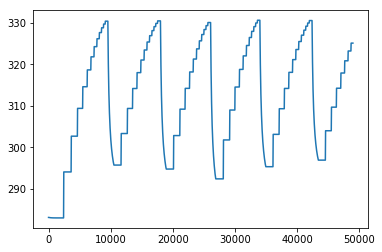

In [36]:
#plotting the one graph
plt.plot(frame.Time[:safery_len], frame['RT_temperature.T'][:safery_len])
plt.show()

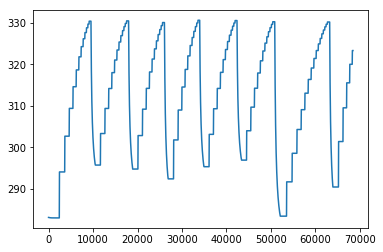

In [37]:
plt.plot(frame.Time[:safery_len + bad], frame['RT_temperature.T'][:safery_len + bad])
plt.show()

In [55]:
#making np array for RT_temperature
RT_temperarute_data = frame['RT_temperature.T'][:safery_len].values
RT_temperarute_data = RT_temperarute_data.reshape(-1, 1)

In [56]:
RT_temperarute_data[:5].shape

(5, 1)

In [57]:
#normalizing rt temp data
scaler = MinMaxScaler(feature_range=(0, 1))
RT_temperarute_normalized_data = scaler.fit_transform(RT_temperarute_data)
RT_temperarute_normalized_data = RT_temperarute_normalized_data.reshape(-1, 1)

In [58]:
#split into train and test sets
train_size = int(len(RT_temperarute_normalized_data) * 0.67)
test_size = len(RT_temperarute_normalized_data) - train_size
train, test = RT_temperarute_normalized_data[0:train_size,:], RT_temperarute_normalized_data[train_size:len(RT_temperarute_normalized_data),:]
print len(train), len(test)

33500 16500


In [59]:
#making a function to create a new dataset
#dataset is numpy array
#look_back is the number of previous time steps to use as imput variables to predict the next time period
#default func will create a dataset where X is the number of passengers at a given time (t)
# Y is the number of passengers at the next time (t+1)
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        next_portion = dataset[i:(i + look_back), 0]
        dataX.append(next_portion)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [60]:
#reshape into X = t and Y = t + 1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [68]:
#reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [69]:
#create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_dim = look_back))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [71]:
model.fit(trainX, trainY, nb_epoch = 100, batch_size = 1, verbose=2)

Epoch 1/100
122s - loss: 0.0017
Epoch 2/100
112s - loss: 8.5059e-06
Epoch 3/100
103s - loss: 2.2813e-06
Epoch 4/100
114s - loss: 2.1479e-06
Epoch 5/100
96s - loss: 2.1576e-06
Epoch 6/100
98s - loss: 2.2263e-06
Epoch 7/100
89s - loss: 2.1071e-06
Epoch 8/100
85s - loss: 2.0342e-06
Epoch 9/100
85s - loss: 2.0749e-06
Epoch 10/100
85s - loss: 1.9979e-06
Epoch 11/100
86s - loss: 1.9855e-06
Epoch 12/100
86s - loss: 1.9602e-06
Epoch 13/100
85s - loss: 1.9105e-06
Epoch 14/100
83s - loss: 1.8897e-06
Epoch 15/100
87s - loss: 1.9290e-06
Epoch 16/100
111s - loss: 1.8286e-06
Epoch 17/100
111s - loss: 1.8160e-06
Epoch 18/100
110s - loss: 1.7965e-06
Epoch 19/100
94s - loss: 1.7720e-06
Epoch 20/100
90s - loss: 1.7835e-06
Epoch 21/100
111s - loss: 1.7423e-06
Epoch 22/100
107s - loss: 1.7812e-06
Epoch 23/100
93s - loss: 1.7360e-06
Epoch 24/100
87s - loss: 1.7090e-06
Epoch 25/100
85s - loss: 1.7111e-06
Epoch 26/100
83s - loss: 1.7150e-06
Epoch 27/100
84s - loss: 1.6972e-06
Epoch 28/100
83s - loss: 1.6849e

In [72]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.04 RMSE
Test Score: 0.03 RMSE


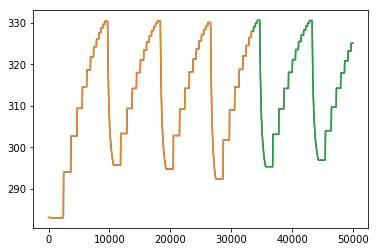

In [75]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(RT_temperarute_normalized_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(RT_temperarute_normalized_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(RT_temperarute_normalized_data)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(RT_temperarute_normalized_data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()